#### Desafío

¿Puedes construir una historia para predecir la cantidad de agua en cada masa de agua? El reto es determinar cómo las características influyen en la disponibilidad de agua de cada masa de agua presentada. Para ser más directos, al comprender mejor los volúmenes, podrán garantizar la disponibilidad de agua para cada intervalo de tiempo del año.

El intervalo de tiempo se define como día/mes, según las medidas disponibles para cada masa de agua. Los modelos deben capturar los volúmenes de cada masa de agua (por ejemplo, si un modelo opera con un intervalo mensual, se espera un pronóstico mensual).

El resultado deseado es un cuaderno que pueda generar cuatro modelos matemáticos, uno para cada categoría de cuerpo de agua (acuíferos, manantiales de agua, río, lago) que podrían aplicarse a cada cuerpo de agua.

In [377]:
# Instala los paquetes del archivo requirements.txt si no están instalados
import os
import sys
import subprocess

# Ruta al archivo requirements.txt
requirements_path = "/workspaces/Tutorial-de-Series-Temporales/requirements.txt"

# Verifica si el archivo existe
if os.path.exists(requirements_path):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", requirements_path])
    except Exception as e:
        print(f"Error instalando paquetes: {e}")
else:
    print("Archivo requirements.txt no encontrado.")

Defaulting to user installation because normal site-packages is not writeable


### Librerias

In [378]:
import numpy as np
import pandas as pd
import seaborn as sns  
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime, date 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
import math
from colorama import Fore, Style
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


### 1.- Limpieza de datos y visualizacion

Leemos nuestro archivo, eliminamos NaN values y dejamos la tabla limpia para poder trabajar con la data importante

In [379]:
df = pd.read_csv("/workspaces/Tutorial-de-Series-Temporales/data/Data Agua/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [380]:
df = df[df.	Hydrometry_Fiume_Chiascio_Petrignano.notna()].reset_index(drop=True)
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)
df.head()


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [381]:
df.columns = ['Fecha', 'lluvia', 'profundidad_del_agua_subterránea', 'temperatura', 'volumen_de_drenaje', 'hidrometria_fluvial']
targets = ['profundidad_del_agua_subterránea']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Fecha,lluvia,profundidad_del_agua_subterránea,temperatura,volumen_de_drenaje,hidrometria_fluvial
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Como tenemos que analizar dia/mes, nos centraremos como data main en la columna "Fecha", pero primero lo convertiremos en una fecha a un formato para trabajar mejor (usando TimeSeries)

In [382]:
df['Fecha'] = pd.to_datetime(df['Fecha'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Fecha'])

,Fecha,lluvia,profundidad_del_agua_subterránea,temperatura,volumen_de_drenaje,hidrometria_fluvial
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


Con la limpieza hecha, y con los datos necesarios, empezamos a definir las caracteristicas para un mejor entendimiento y trabajar sobre ellos

Vamos a dar definicion de los datos que tenemos, y cual es nuestro objetivo. Con ello conseguiremos una estructura solida y que cualquier persona entienda el proceso.

Caracteristicas:
- **Lluvia**: indica la cantidad de lluvia caida en milimetros (mm)
- **Temperatura**: indica la temperatura (°C)
- **Volumen de Drenaje**: indica el volumen de agua tomada de la planta potabilizadora (m³)
- **Hidrometría Fluvial**: indica el nivel de las aguas subterráneas (m)

Objetivo:
- **Profundidad del agua subterránea**: que indica el nivel del agua subterránea en metros, empezando desde el suelo)

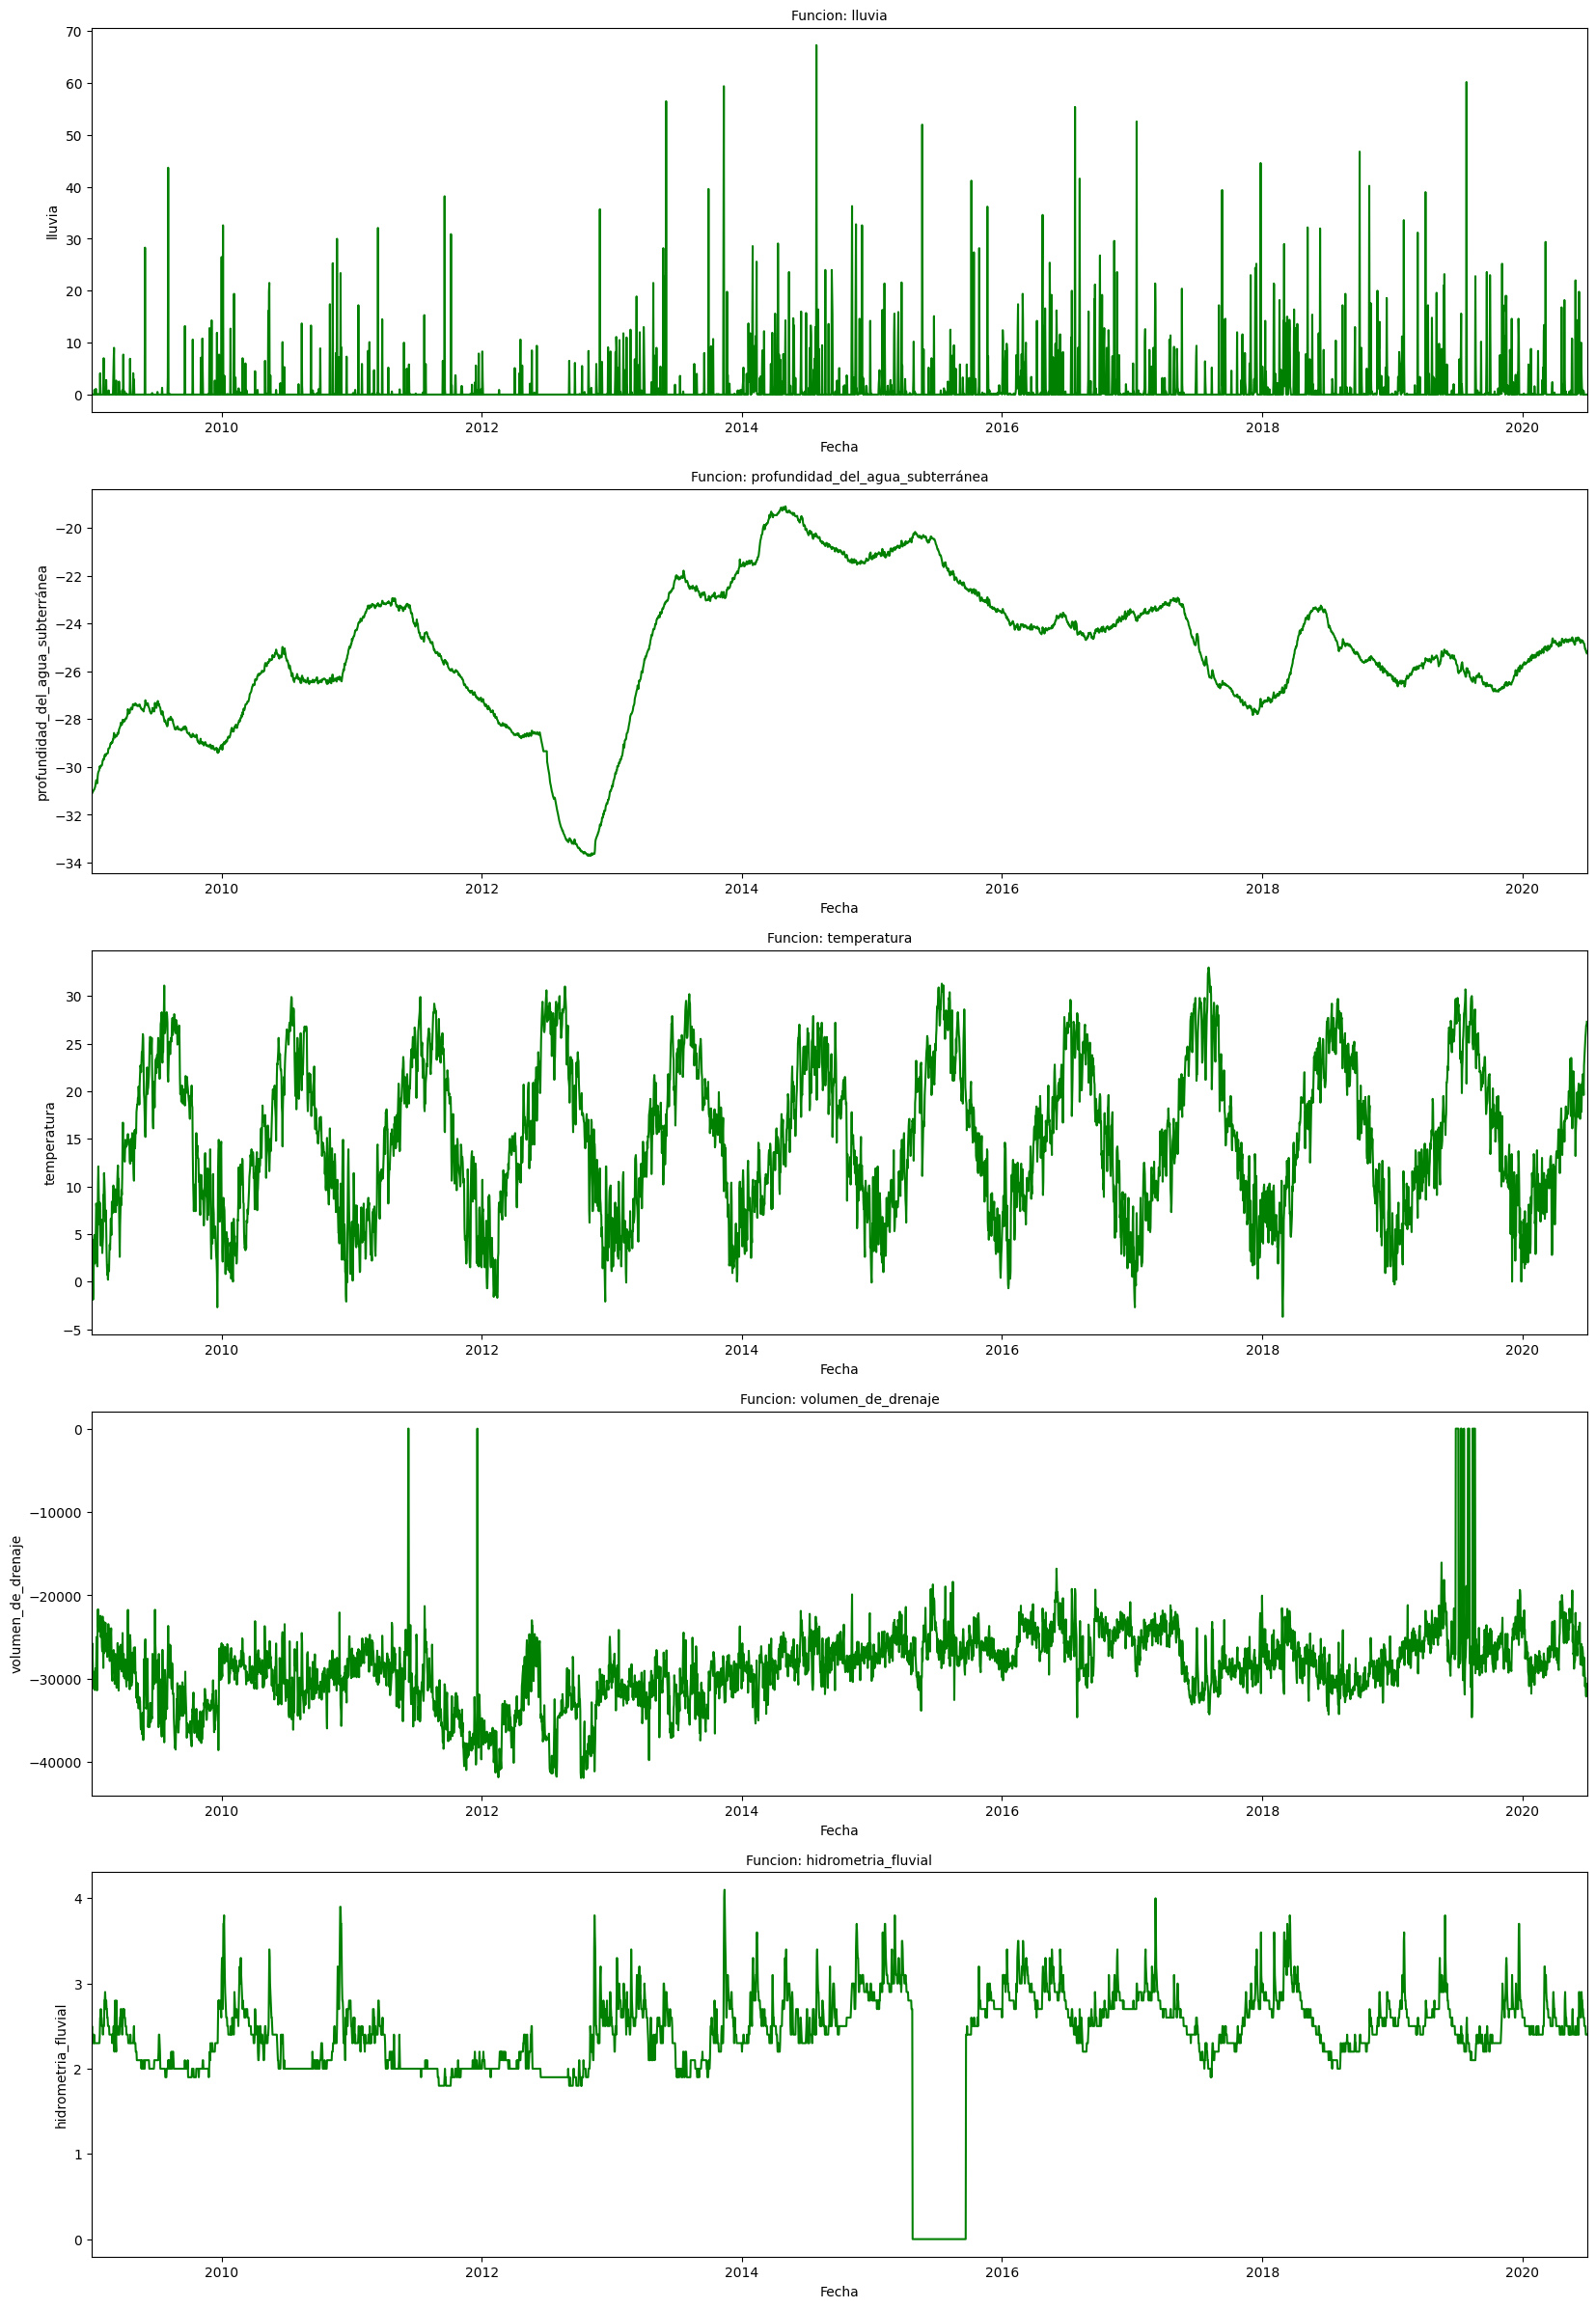

In [383]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 30))

for i, column in enumerate(df.drop('Fecha', axis=1).columns):
    sns.lineplot(x=df['Fecha'], y=df[column].ffill(), ax=ax[i], color='Green')
    ax[i].set_title('Funcion: {}'.format(column), fontsize=10)
    ax[i].set_ylabel(ylabel=column, fontsize=10)
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])     

Ya tenemos la data necesaria, que nos ayudara con nuestro **Objectivo** de analizar la profundidad del agua y que nos indica eso. Pero antes de avanzar, vemos que hay valores NaN, que son la **hidrometria_fluvial** o el **volumen_de_drenaje**. Revisemos que ocurren con ellos, y su disposicion, y si es necesario, rellenarlos.

(Haremos una copia de la data actual, para marcarla en otro color en la grafica, y asi, al rellenar los NaN con datos, poder comparar la diferencia de forma visible, siendo la grafica Roja la original, y la Grafica Verde la modificada)

(np.float64(14245.0), np.float64(18444.0))

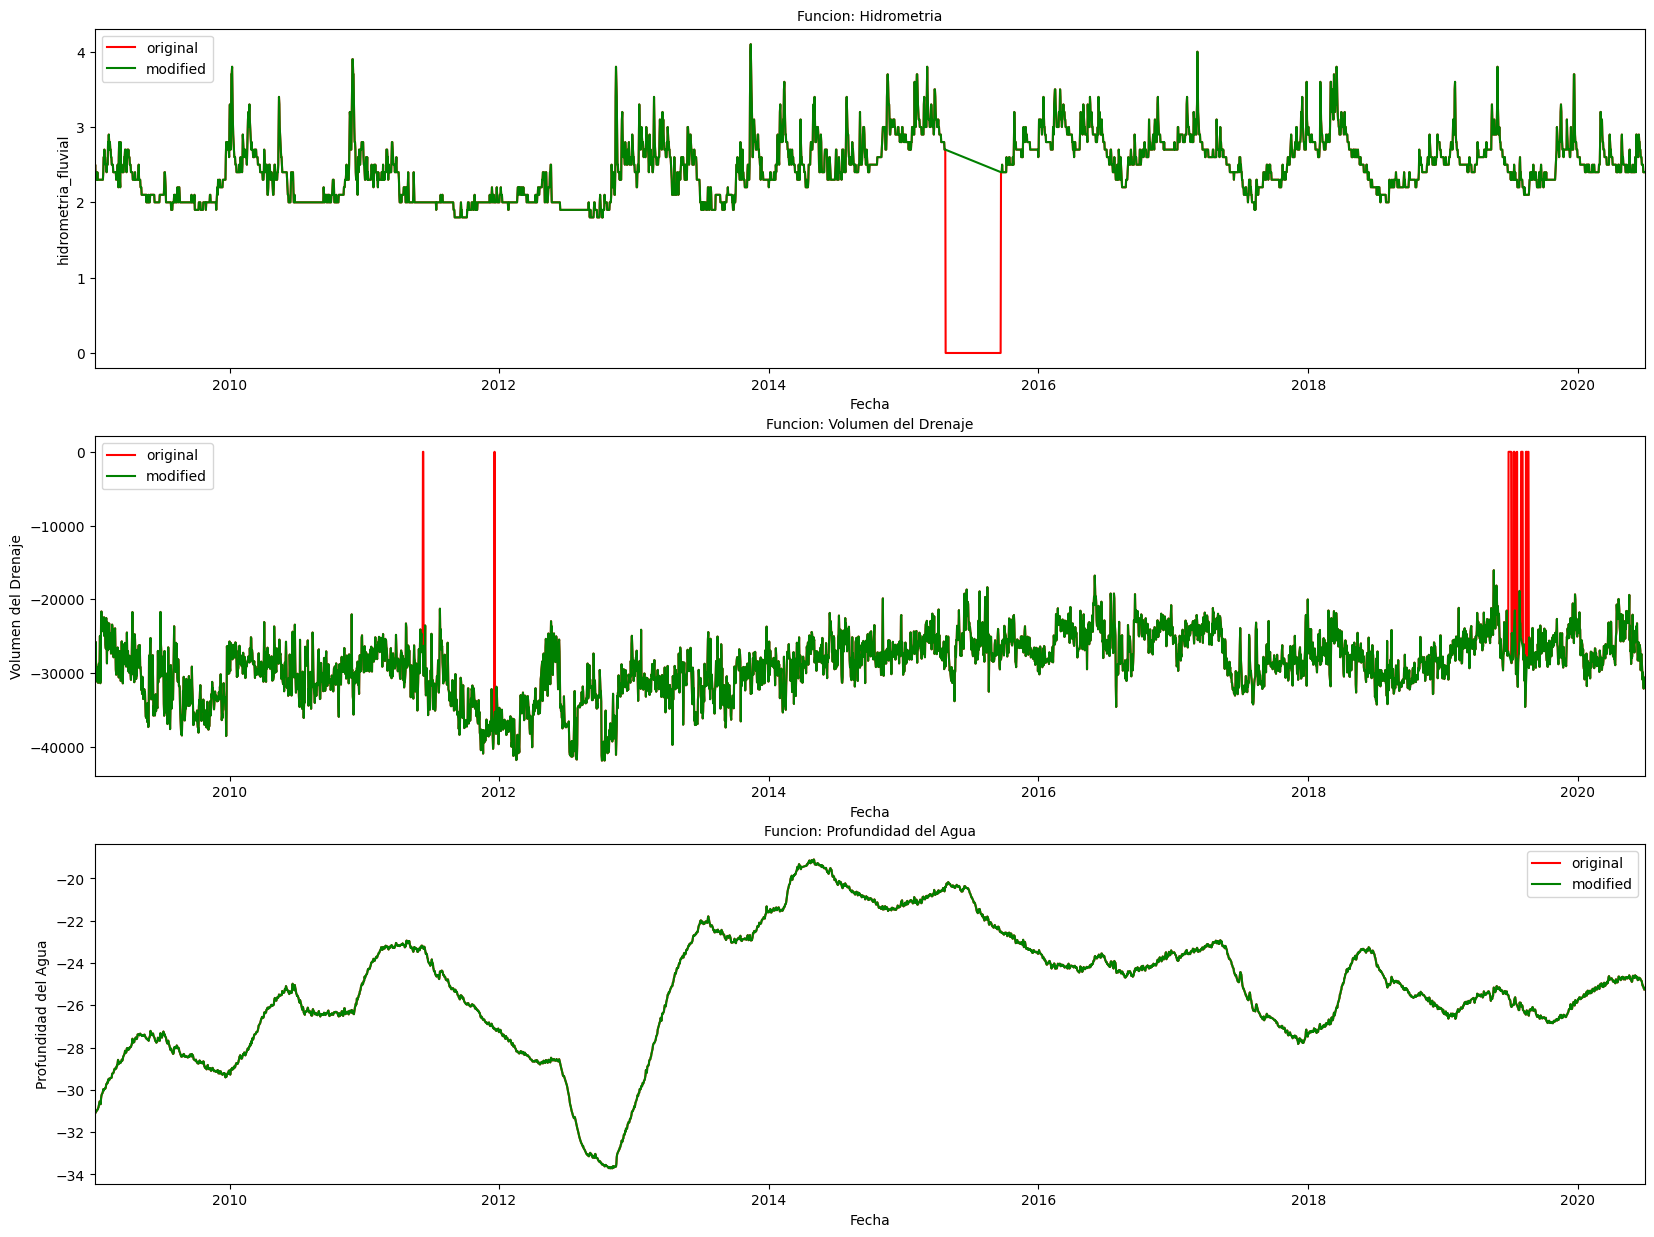

In [384]:
f, ax = plt.subplots(nrows=3, ncols=1, figsize=((20), 15))

#Creamos variables con la vieja informacion, para poder vincularla con la nueva de otro color
old1 = df['hidrometria_fluvial'].copy()
df['hidrometria_fluvial'] = df['hidrometria_fluvial'].replace(0, np.nan)

sns.lineplot(x=df['Fecha'], y=old1, ax=ax[0], color='red', label='original')
sns.lineplot(x=df['Fecha'], y=df['hidrometria_fluvial'].fillna(np.inf), ax=ax[0], color='green', label='modified')
ax[0].set_title('Funcion: Hidrometria', fontsize=10)
ax[0].set_ylabel(ylabel='hidrometria_fluvial', fontsize=10)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])

old2 = df['volumen_de_drenaje'].copy()
df['volumen_de_drenaje'] = df['volumen_de_drenaje'].replace(0, np.nan)

sns.lineplot(x=df['Fecha'], y=old2, ax=ax[1], color='red', label='original')
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'].fillna(np.inf), ax=ax[1], color='green', label='modified')
ax[1].set_title('Funcion: Volumen del Drenaje', fontsize=10)
ax[1].set_ylabel(ylabel='Volumen del Drenaje', fontsize=10)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])

old3 = df['profundidad_del_agua_subterránea'].copy()
df['profundidad_del_agua_subterránea'] = df['profundidad_del_agua_subterránea'].replace(0, np.nan)

sns.lineplot(x=df['Fecha'], y=old3, ax=ax[2], color='red', label='original')
sns.lineplot(x=df['Fecha'], y=df['profundidad_del_agua_subterránea'].fillna(np.inf), ax=ax[2], color='green', label='modified')
ax[2].set_title('Funcion: Profundidad del Agua', fontsize=10)
ax[2].set_ylabel(ylabel='Profundidad del Agua', fontsize=10)
ax[2].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])


Ahora que sabemos donde estan los valores perdidos, vamos a tratarlos

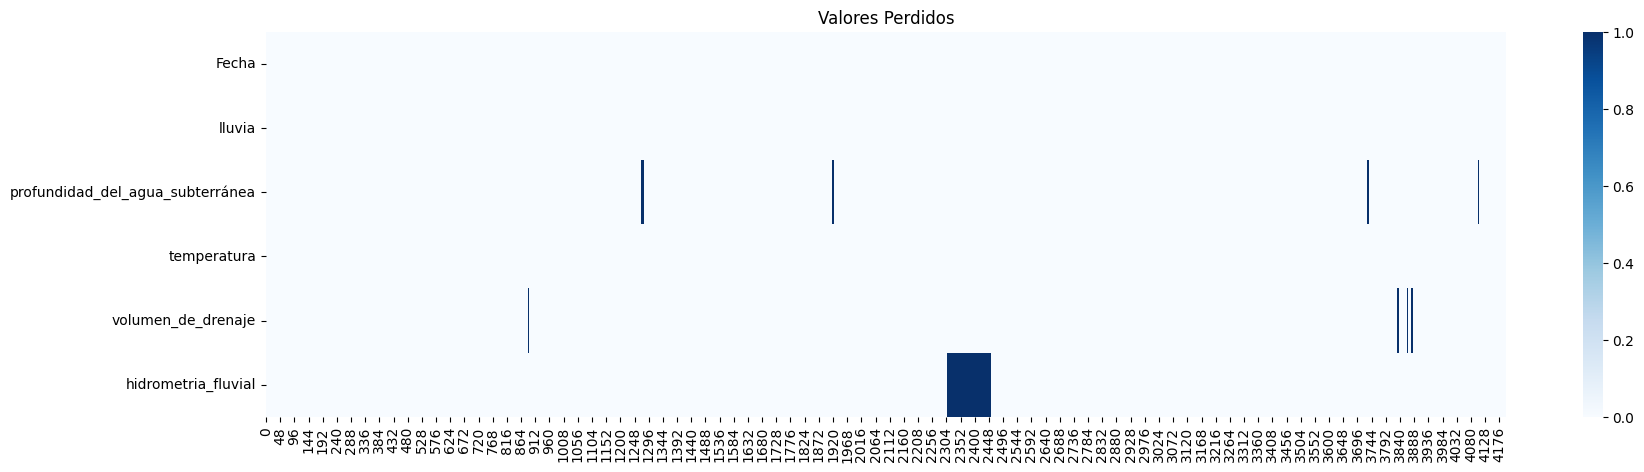

In [385]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Valores Perdidos', fontsize=12)

for tick in ax.yaxis.get_major_ticks():
    ax.tick_params(axis='y', labelsize=10)
plt.show()

Interpolamos la informacion faltante para poder tener una data mas concisa

(np.float64(14245.0), np.float64(18444.0))

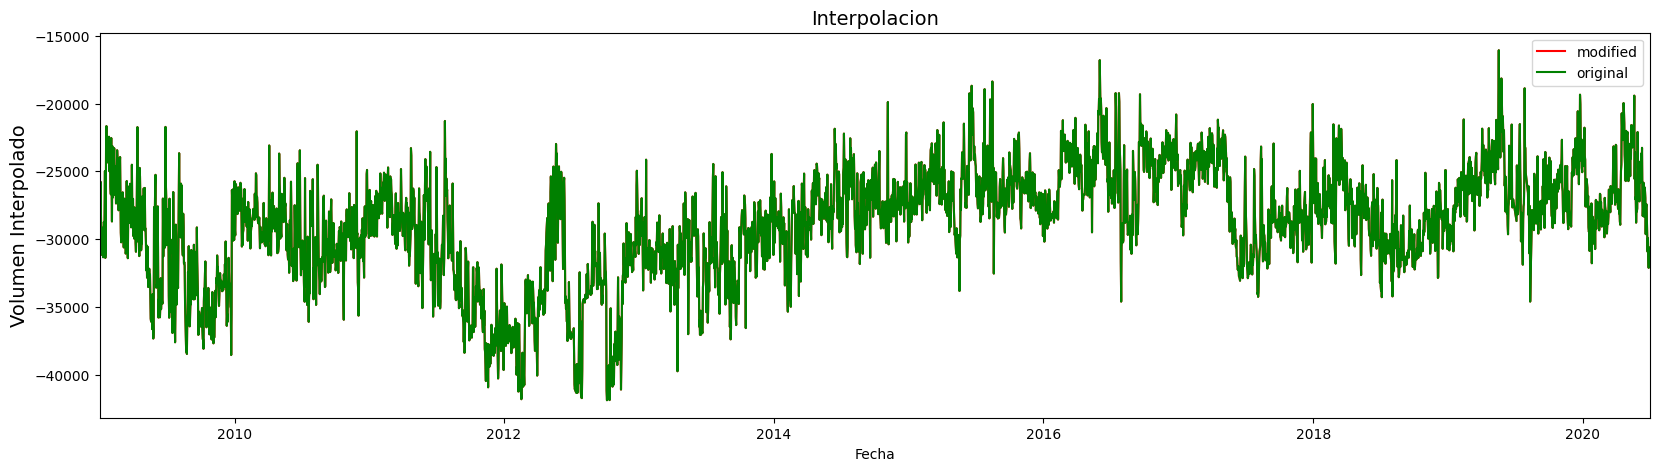

In [386]:
#Ejemplo con Volumen de drenaje

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'].interpolate(), ax=ax, color='red', label = 'modified')
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'].fillna(np.inf), ax=ax, color='green', label = 'original')
ax.set_title(f'Interpolacion', fontsize=14)
ax.set_ylabel(ylabel='Volumen Interpolado', fontsize=14)
ax.set_xlim([date(2009, 1, 1), date(2020, 7, 1)])

In [387]:
df['volumen_de_drenaje'] = df['volumen_de_drenaje'].interpolate()
df['hidrometria_fluvial'] = df['hidrometria_fluvial'].interpolate()
df['profundidad_del_agua_subterránea'] = df['profundidad_del_agua_subterránea'].interpolate()

Ya no tenemos la data "vacia"" como antes, asi que ahora si podemos trabajar de forma correcta, ya que no marca el color modificado. Ahora solo tocaria hacer un "Resample" 

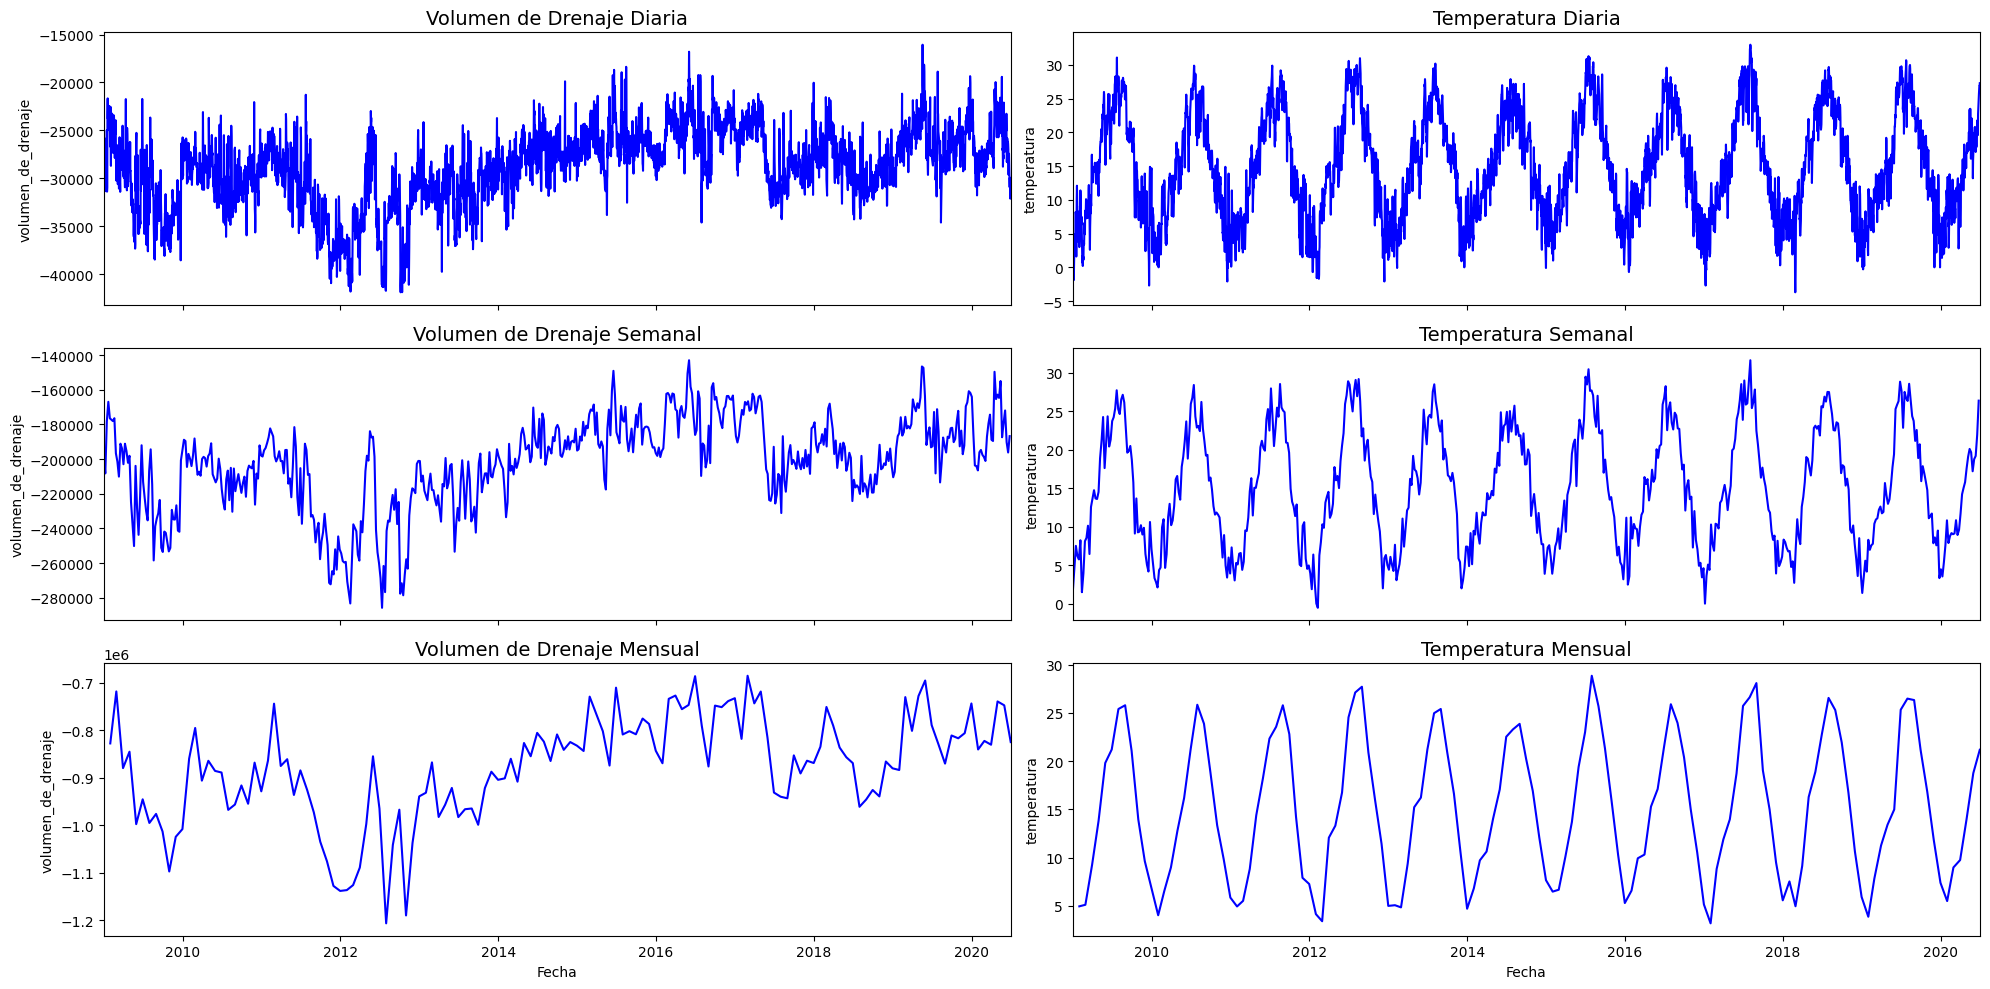

In [388]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(20, 10))

# Column 1: Volumen de Drenaje
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'], color='blue', ax=ax[0, 0])
ax[0, 0].set_title('Volumen de Drenaje Diaria', fontsize=14)

resampled_df = df[['Fecha', 'volumen_de_drenaje']].resample('7D', on='Fecha').sum().reset_index()
sns.lineplot(x=resampled_df['Fecha'], y=resampled_df['volumen_de_drenaje'], color='blue', ax=ax[1, 0])
ax[1, 0].set_title('Volumen de Drenaje Semanal', fontsize=14)

resampled_df = df[['Fecha', 'volumen_de_drenaje']].resample('ME', on='Fecha').sum().reset_index()
sns.lineplot(x=resampled_df['Fecha'], y=resampled_df['volumen_de_drenaje'], color='blue', ax=ax[2, 0])
ax[2, 0].set_title('Volumen de Drenaje Mensual', fontsize=14)

# Ajuste del eje X para la columna izquierda
for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])

# Column 2: Temperatura
sns.lineplot(x=df['Fecha'], y=df['temperatura'], color='blue', ax=ax[0, 1])
ax[0, 1].set_title('Temperatura Diaria', fontsize=14)

resampled_df = df[['Fecha', 'temperatura']].resample('7D', on='Fecha').mean().reset_index()
sns.lineplot(x=resampled_df['Fecha'], y=resampled_df['temperatura'], color='blue', ax=ax[1, 1])
ax[1, 1].set_title('Temperatura Semanal', fontsize=14)

resampled_df = df[['Fecha', 'temperatura']].resample('ME', on='Fecha').mean().reset_index()
sns.lineplot(x=resampled_df['Fecha'], y=resampled_df['temperatura'], color='blue', ax=ax[2, 1])
ax[2, 1].set_title('Temperatura Mensual', fontsize=14)

# Ajuste del eje X para la columna derecha
for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 7, 1)])

plt.tight_layout()
plt.show()

In [389]:
ds = df[['Fecha', 'lluvia', 'profundidad_del_agua_subterránea', 'temperatura', 'volumen_de_drenaje', 'hidrometria_fluvial']].resample('7D', on='Fecha').mean().reset_index(drop=False)
df = ds.copy()

## 2.- EDA (análisis exploratorio de datos)

Vamos a visualizar la informacion usando una media y una variable standart para mejor visualizacion (a la vez que podemos trabajar la data para dar formato a estacionabilidad)

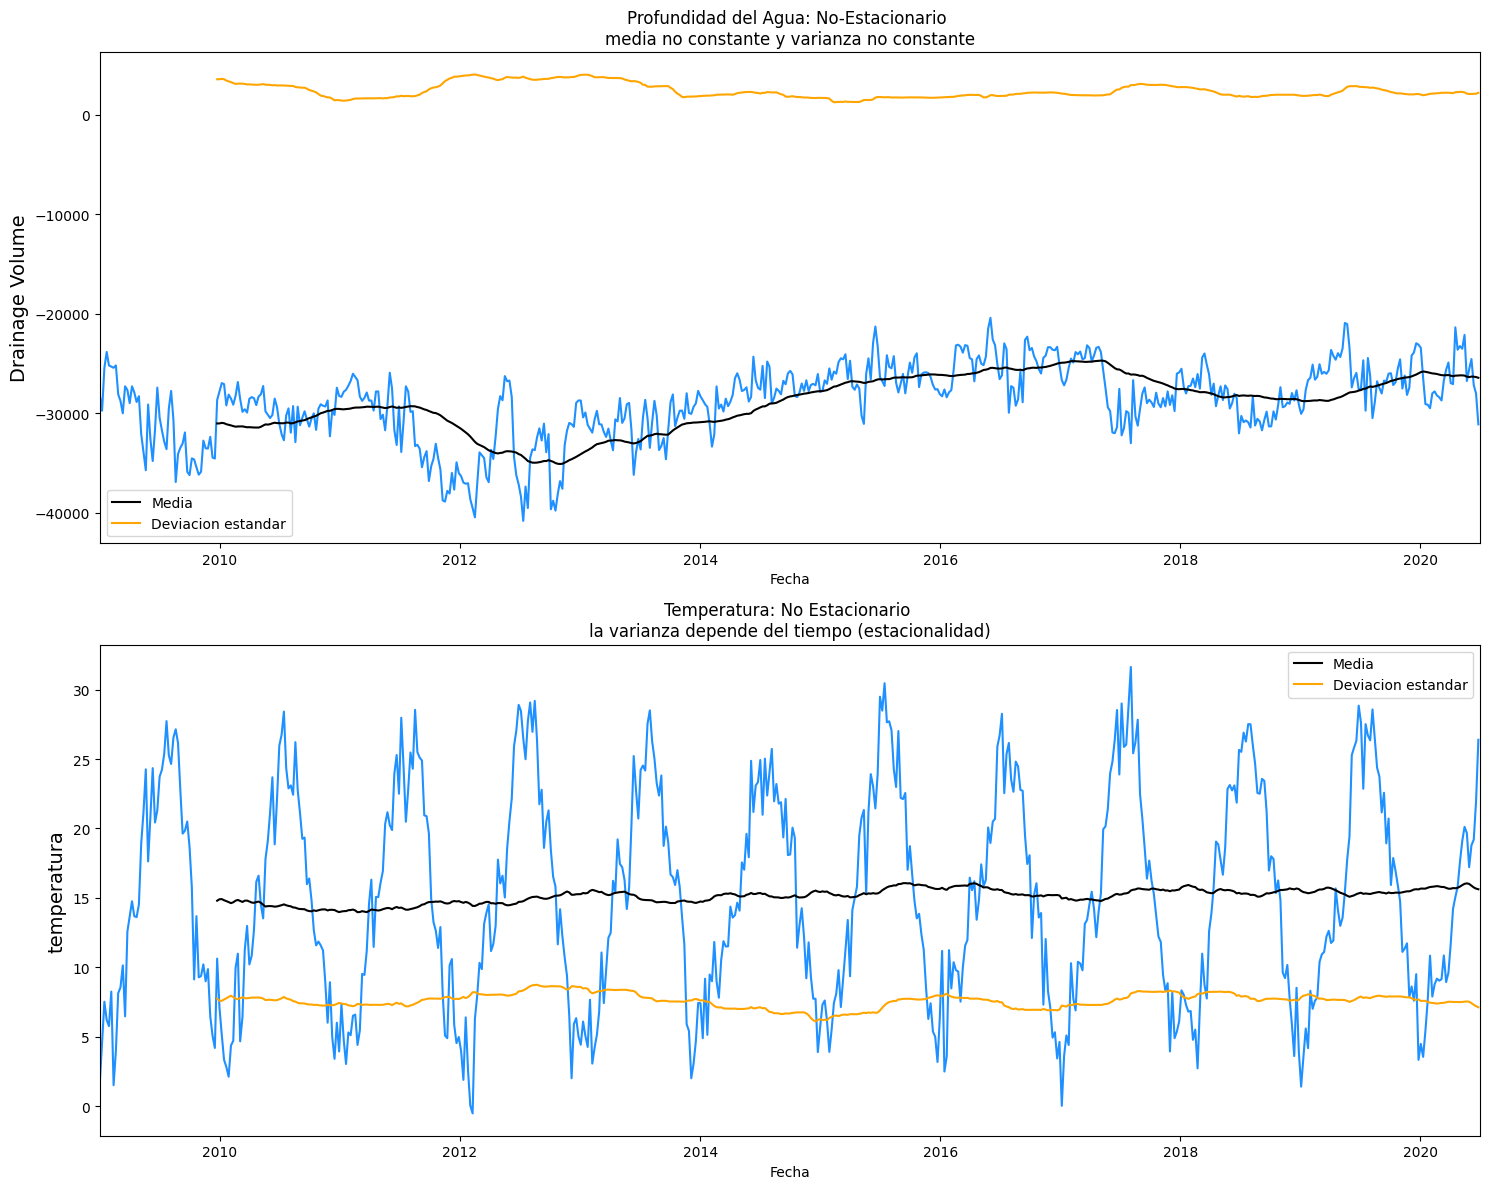

In [390]:
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='Media')
sns.lineplot(x=df['Fecha'], y=df['volumen_de_drenaje'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='Deviacion estandar')
ax[0].set_title('Profundidad del Agua: No-Estacionario \nmedia no constante y varianza no constante', fontsize=12)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['Fecha'], y=df['temperatura'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['Fecha'], y=df['temperatura'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='Media')
sns.lineplot(x=df['Fecha'], y=df['temperatura'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='Deviacion estandar')
ax[1].set_title('Temperatura: No Estacionario \nla varianza depende del tiempo (estacionalidad)', fontsize=12)
ax[1].set_ylabel(ylabel='temperatura', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

Vamos a extraer datos empezando por las Estaciones usando Statsmodel y defininiendo como queremos la data para poder comparar la correlacion con las demas variables.

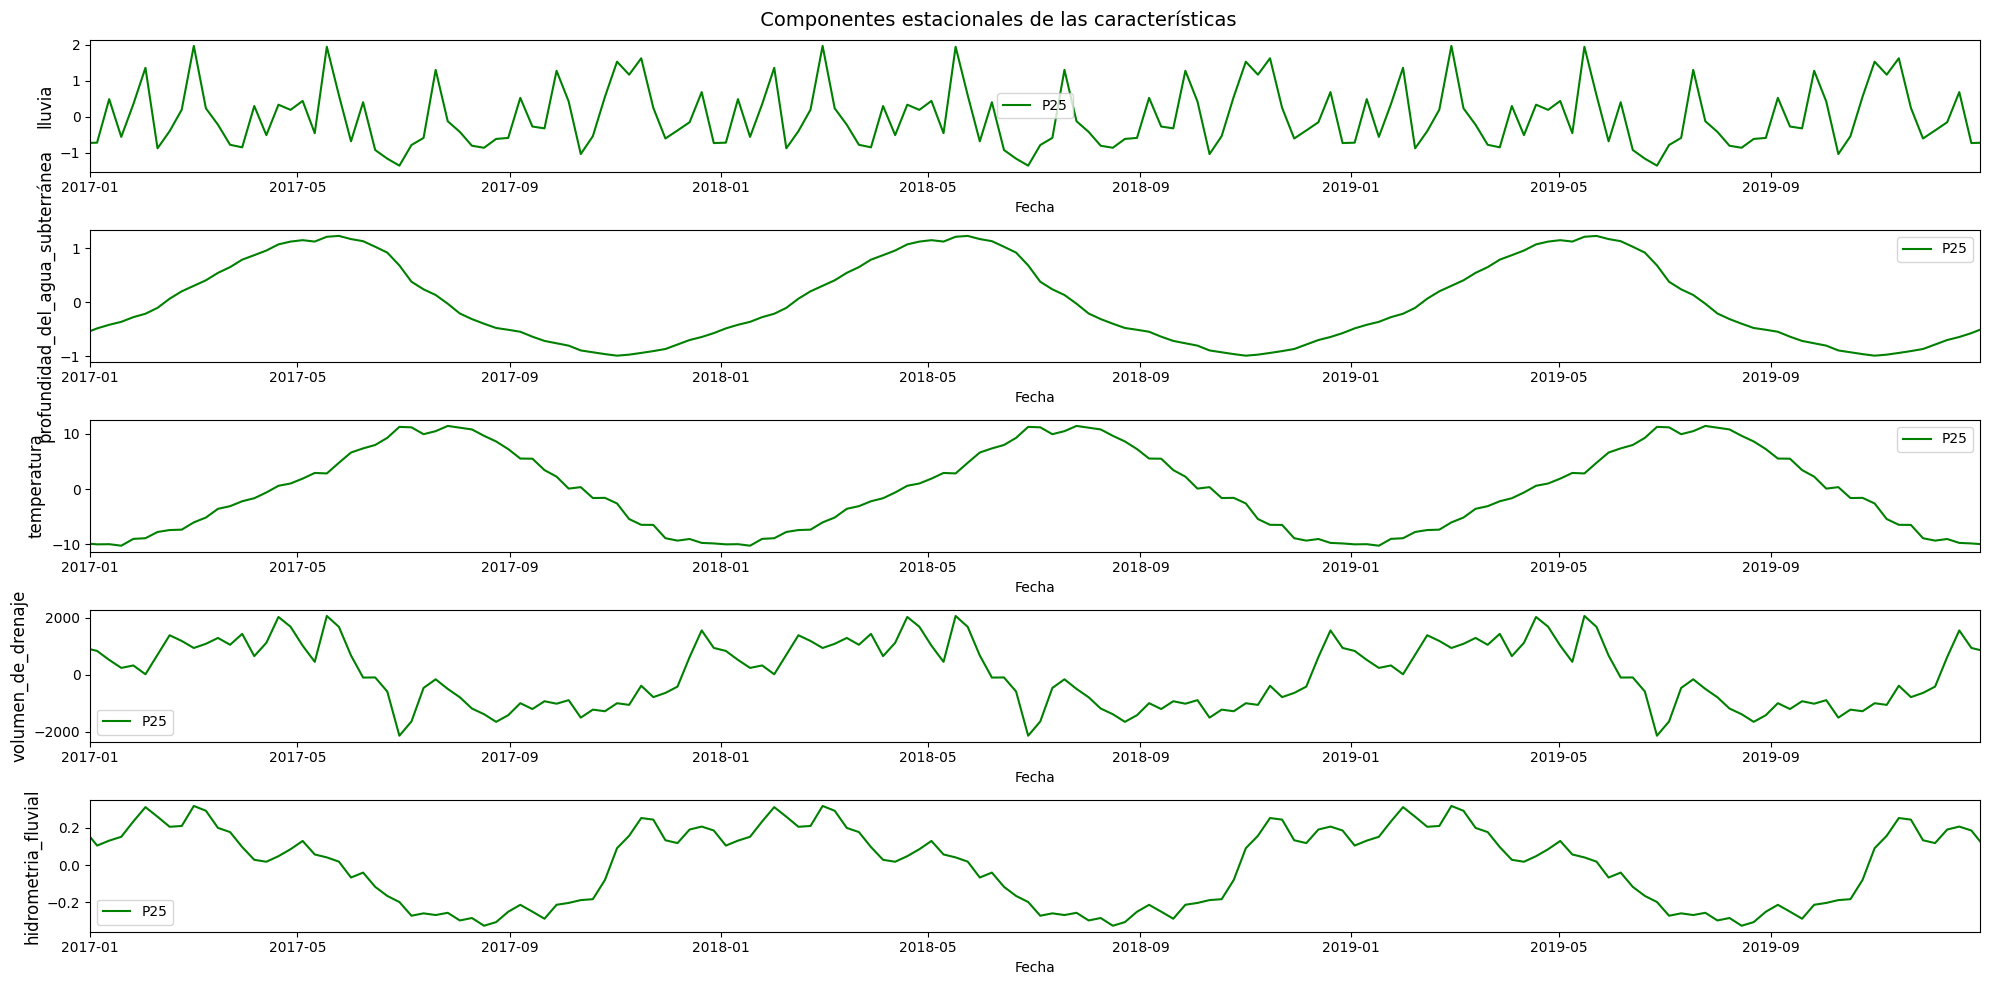

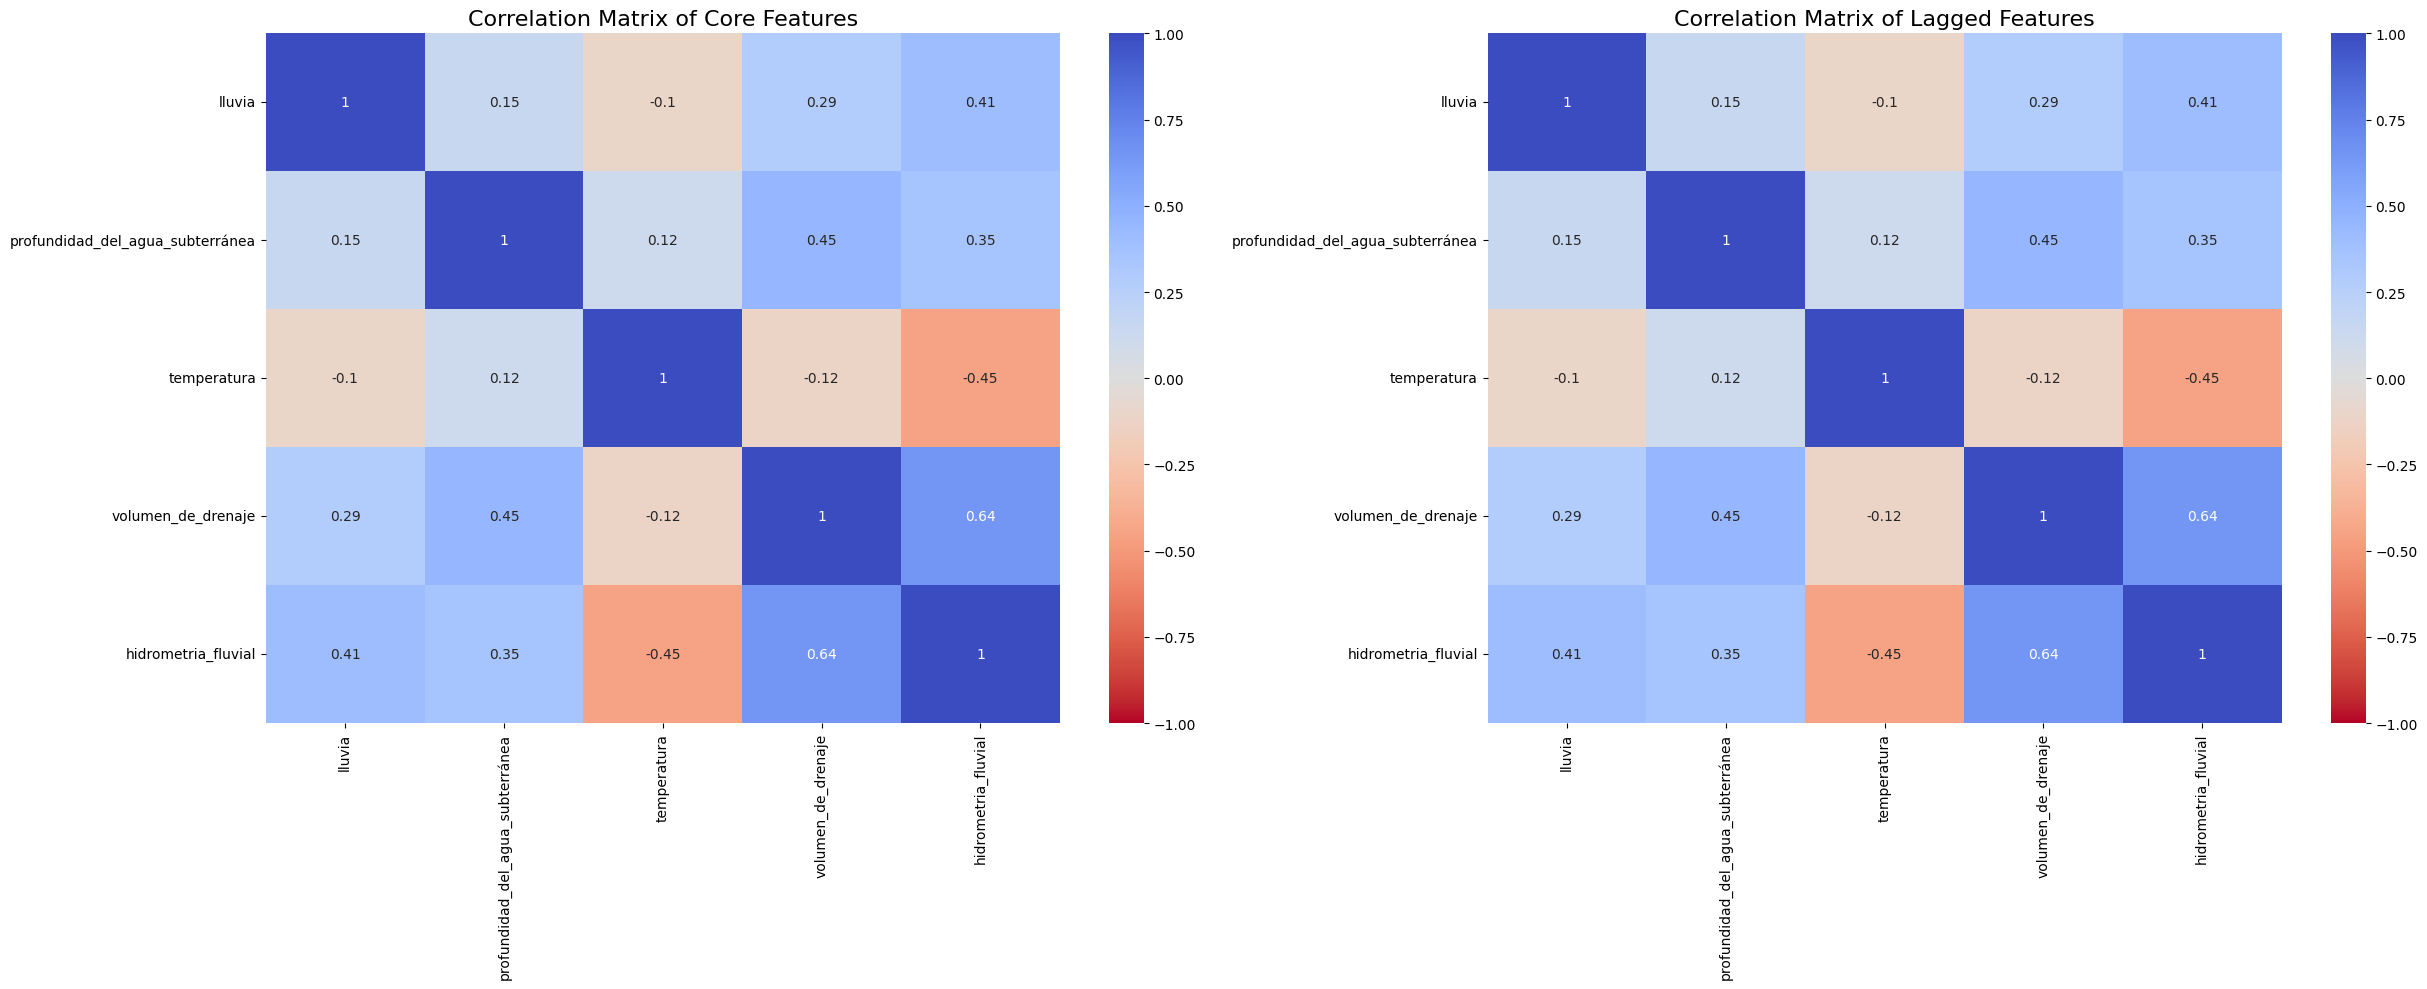

In [391]:
Columnas1 =  ['lluvia', 'profundidad_del_agua_subterránea', 'temperatura', 'volumen_de_drenaje', 'hidrometria_fluvial']
weeks_in_month = 4

for column in Columnas1:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

#Graficas
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(20, 10))
f.suptitle(' Componentes estacionales de las características', fontsize=14)

for i, column in enumerate(Columnas1):
    sns.lineplot(x=df['Fecha'], y=df[column + '_seasonal'], ax=ax[i], color='green', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=12)
    ax[i].set_xlim([date(2017, 1, 1), date(2019, 12, 31)])
    
plt.tight_layout()
plt.show()

#Mapa de Calor con estaciones

for column in Columnas1:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

Columnas_estacionales = ['profundidad_del_agua_subterránea_seasonal','temperatura_seasonal_shift_b_2m','volumen_de_drenaje_seasonal_shift_2m', 'hidrometria_fluvial_seasonal_shift_3m']
correlacion = df[Columnas_estacionales].corr()
correlacion = df[Columnas1].corr()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
sns.heatmap(correlacion, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)
sns.heatmap(correlacion, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

Gracias a dividir nuestra data en estaciones, podemos definir la informacion enseñada como:

- Profundiad del agua subterranea -> Alcanza su pico maximo entre Mayo - Junio y su pico minimo entre Noviembre - Diciembre
- Temperatura -> Su maximo es alcanzado en Agosto (Verano maximo) y su minimo en Enero (Invierno maximo)
- Volumen de drenaje -> Su minimo es alcanzado en Julio y su maximo entre Finales de Abril - Inicios de Junio
- Hidrometria Fluvial -> Alcanza su maximo entre febrero y marzo y su minimo alrededor Agosto/Septiembre

Ademas que la temperatura esta muy correlacionada con la Hidrometria Fluvial

## 3.- Series Temporales

In [400]:
N_SPLITS = 3

X = df['Fecha']
y = df['profundidad_del_agua_subterránea']

folds = TimeSeriesSplit(n_splits=N_SPLITS)


#### 3.1 - Series temporales univariantes con ARIMA

MAE: 1.6210911114525532
RMSE: 1.9055484993639


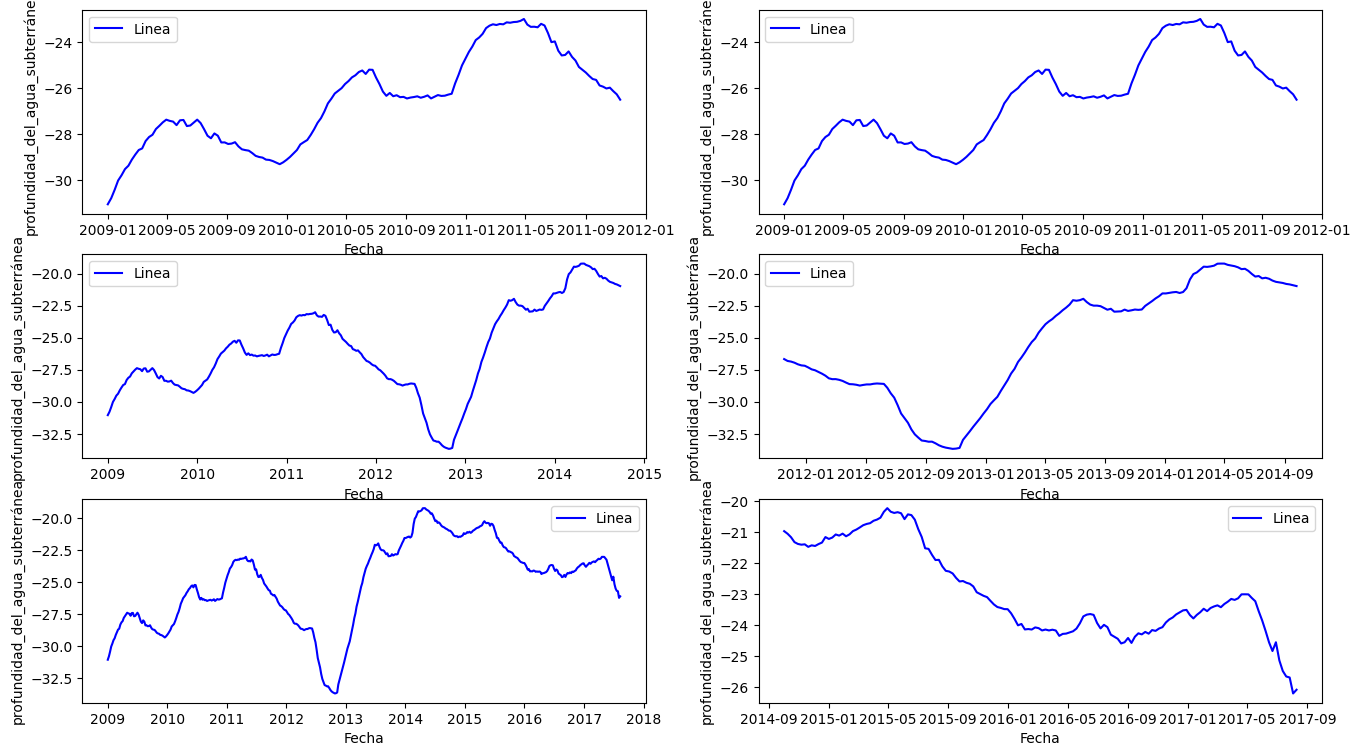

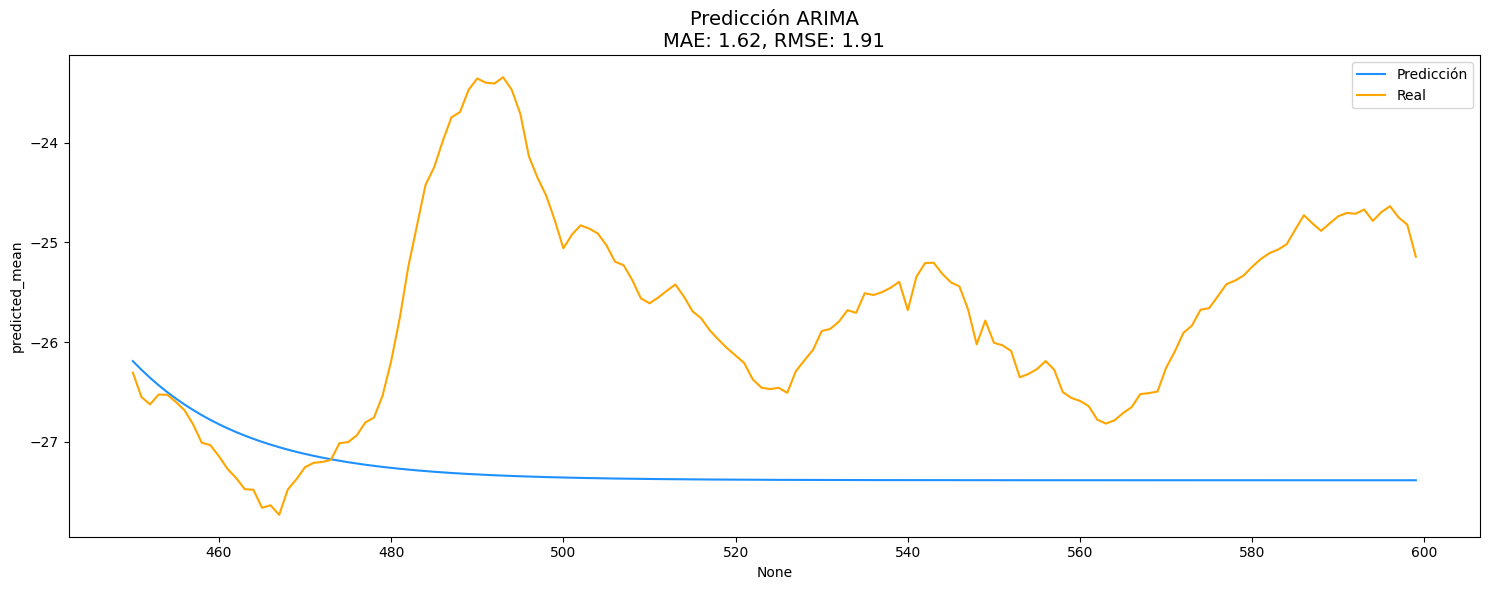

In [401]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(x=X_train,y=y_train,ax=ax[i,0],color='blue',label='Linea')
    sns.lineplot(x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], ax=ax[i,1], color='blue', label='Linea')

# Modelo
model = ARIMA(y_train, order=(1, 1, 1))
model_fit = model.fit()

# Prediccion con ARIMA
forecast = model_fit.forecast(steps=len(X_valid))
y_pred = forecast

# Calcular Metricas
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'MAE: {}'.format(score_mae))
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

f, ax = plt.subplots()
f.set_figheight(6)
f.set_figwidth(15)

# Línea de predicción
sns.lineplot(x=y_pred.index, y=y_pred, ax=ax, label='Predicción', color='dodgerblue')
# Línea real
sns.lineplot(x=y_valid.index, y=y_valid, ax=ax, label='Real', color='orange')

# Título con métricas
ax.set_title(f'Predicción ARIMA\nMAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

#### 3.2 - Series temporales univariantes con Prophet

In [403]:
feature_columns = ['lluvia', 'temperatura', 'volumen_de_drenaje', 'hidrometria_fluvial']
target_column = ['profundidad_del_agua_subterránea']

train_size = int(0.85 * len(df))

multivariate_df = df[['Fecha'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,lluvia,temperatura,volumen_de_drenaje,hidrometria_fluvial
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


23:11:50 - cmdstanpy - INFO - Chain [1] start processing


23:11:51 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.9806231219261385


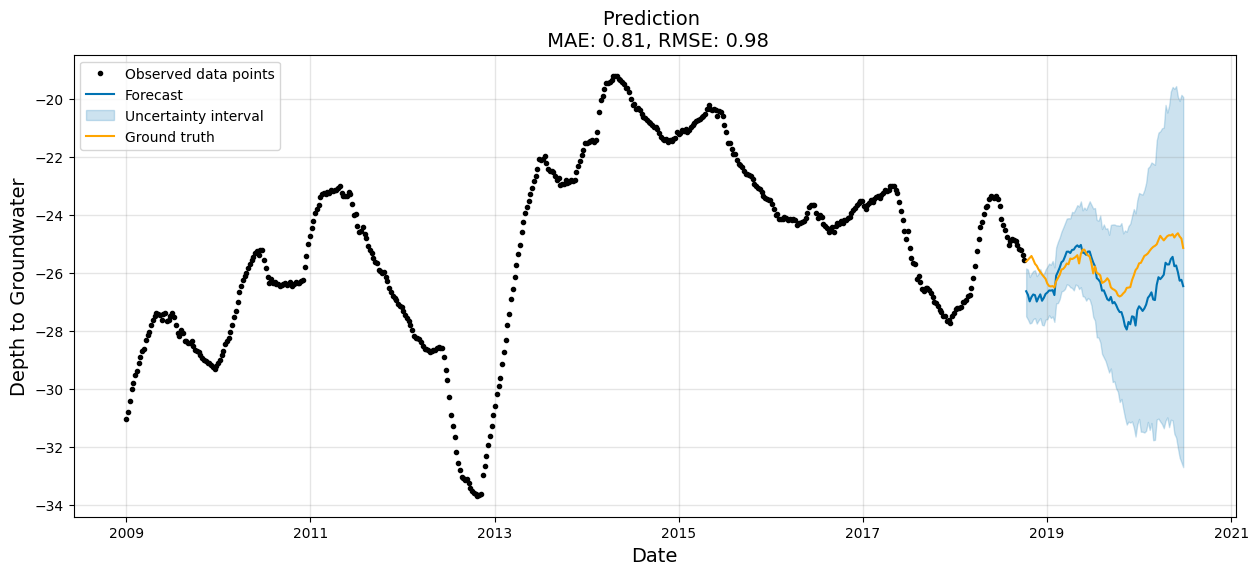

In [405]:
# Mdelo a entrenar
model = Prophet()
model.add_regressor('lluvia')
model.add_regressor('temperatura')
model.add_regressor('volumen_de_drenaje')
model.add_regressor('hidrometria_fluvial')

# Fit the model with train set
model.fit(train)
# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

# Graficala
f, ax = plt.subplots()
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

Con esta informacion tenemos una prediccion usando Series Temporales univariables (ARIMA) y multivariables (Prophet) 